In [31]:
from VUNet.model.vunet import VUnet
from VUNet.data.prjoti import Prjoti_VUNet

from edflow.util import edprint

import torch

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import yaml

# Model and Data setup

Using the config files for the model and the dataset, we set up both model and dataset.

In [81]:
with open('VUNet/configs/base.yaml', 'r') as m_cfg:
    model_config = yaml.safe_load(m_cfg.read())
    
model = VUnet(model_config)

In [3]:
with open('VUNet/configs/prjoti.yaml', 'r') as d_cfg:
    data_config = yaml.safe_load(d_cfg.read())
    
dset = Prjoti_VUNet(data_config)
dset.expand = True

Note that we need to set `dset.expand = True`. Otherwise we have no access to some of the data, as the dataloading process working in the background does not actually load the data right away and only returns a loader function. Upon setting the dataset flag `expand` to `True`, these loader functions are evaluated when calling the `__getitem__` method of the dataset, i.e. when calling `dset[idx]`.

Let's have a look at the content of the dataset:

In [10]:
example = dset[0]
edprint(example)

|         Name |      Type |         Content |
|--------------|-----------|-----------------|
|     stickman |   ndarray |   (256, 256, 3) |
|   appearance |   ndarray |   (256, 256, 3) |
|       target |   ndarray |   (256, 256, 3) |
|       index_ |       int |               0 |


As we can see above, each example in the dataset contains three image like arrays: `stickman` and `appearance` are the two inputs to VUNet, `target` is the ground truth we want VUNet to generate given the two inputs.

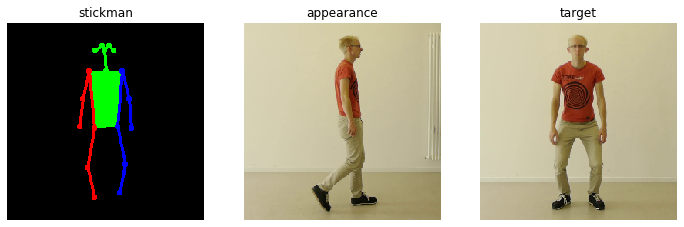

In [29]:
f, [ax1, ax2, ax3] = _, AX = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow((example['stickman'] + 1.) / 2.)
ax1.set_title('stickman')
ax2.imshow((example['appearance'] + 1.) / 2.)
ax2.set_title('appearance')
ax3.imshow((example['target'] + 1. ) / 2.)
ax3.set_title('target')

for ax in AX:
    ax.axis('off')

In [18]:
edprint(dset.labels)

|         Name |     Type |         Content |
|--------------|----------|-----------------|
|          fid |   memmap |         (1052,) |
|          box |   memmap |       (1052, 4) |
|      kps_rel |   memmap |   (1052, 18, 2) |
|    keypoints |   memmap |   (1052, 18, 2) |
|   confidence |   memmap |      (1052, 18) |
|      action_ |   memmap |         (1052,) |
|        crop_ |   memmap |         (1052,) |
|       frame_ |   memmap |         (1052,) |


The dataset has also additional information for each example, like the frame index or time step `fid` of the `stickman` and also `target` shown in the example. The `box` tells us, where in the `frame_` the `crop_` is located. The keypoints `kps_rel` are converted into the `stickman` upon loading the example as seen above, `keypoints` are the locations of all joints in coordinates relative to actual frame. The `confidence` values of each joint location is not used in the current training but could potentially be leveraged.

We can take a look at the full frame by accessing the `base` attribute of the dataset. Take a look at the code defining the dataset to understand what's going on 😉. In any case enjoy the images below to understand where the ones above come from.

In [25]:
dset.base.expand = True
base_example = dset.base[0]
dset.base.expand = False

edprint(base_example)

|                 Name |      Type |                Content |
|----------------------|-----------|------------------------|
|               action |       str |                   jump |
|                 crop |   ndarray |          (256, 256, 3) |
|                frame |   ndarray |        (1080, 1920, 3) |
|               index_ |       int |                      0 |
|          labels_/fid |     int64 |                      0 |
|          labels_/box |    memmap |                   (4,) |
|      labels_/kps_rel |    memmap |                (18, 2) |
|    labels_/keypoints |    memmap |                (18, 2) |
|   labels_/confidence |    memmap |                  (18,) |
|      labels_/action_ |     int64 |                      0 |
|        labels_/crop_ |      str_ |   crops/jump/00000.png |
|       labels_/frame_ |      str_ |         JJ1/000053.png |


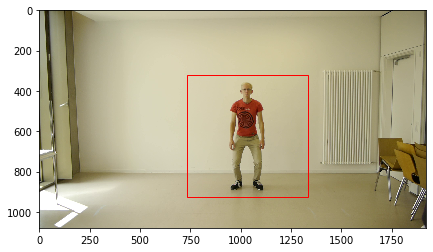

In [28]:
box = base_example['labels_']['box']
xy = box[:2]
w, h = box[2] - box[0], box[3] - box[1]
box = patches.Rectangle(xy, w, h, linewidth=1, edgecolor='r', facecolor='none')

f, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.imshow((base_example['frame'] + 1) / 2)
ax.add_patch(box)

# 🚀 VUNet in action 🚀

Knowing a bit about our data, let us now have a look at the model in action.

⚠️ This assumes you have a trained model at hand. Make sure to follow the steps in `README.md` to train a model. The checkpoint will be in your project folder under `train/checkpoints`.

In [87]:
checkpoint_path = '<path/to/your/checkpoint.ckpt>'

full_state = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model_state = full_state['model']  # we also store the optimize state, which we do not need here

model.load_state_dict(model_state)

<All keys matched successfully>

In [85]:
from VUNet.iterator import np2pt, pt2np

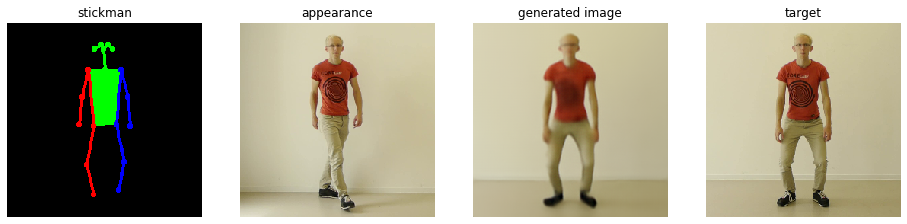

In [88]:
ex = dset[0]  # Change the index!

# Data preparation
stick = np2pt(ex['stickman'][None])  # Simulate batch dimension using np_arr[None]
app = np2pt(ex['appearance'][None])
target = np2pt(ex['target'][None])

# VUNet finally and actually in action! 🚀
out_image = model({'pose': stick, 'appearance': app})

# Back to numpy
out_image = pt2np(out_image)[0]  # remove batch dimension using arr[0]

# Let's see what we got
f, [ax1, ax2, ax3, ax4] = _, AX = plt.subplots(1, 4, figsize=(16, 4))

ax1.imshow((ex['stickman'] + 1.) / 2.)
ax1.set_title('stickman')
ax2.imshow((ex['appearance'] + 1.) / 2.)
ax2.set_title('appearance')
ax3.imshow((out_image + 1. ) / 2.)
ax3.set_title('generated image')
ax4.imshow((ex['target'] + 1. ) / 2.)
ax4.set_title('target')

for ax in AX:
    ax.axis('off')

Now you have the basic knowledge on how to use VUNet. In general `edflow` allows you to automate a lot of things, once you know what you want to evaluate. Take a look at the `edflow.eval.pipeline` to see, what is possible.

✨ Have Fun! ✨